# Conceptual description

As people interact, they tend to become more alike in their beliefs, attitudes and behaviour. In ["The Dissemination of Culture: A Model with Local Convergence and Global Polarization" (1997)](https://www.jstor.org/stable/174371?seq=1#metadata_info_tab_contents), Robert Axelrod presents an agent-based model to explain cultural diffusion. Analogous to Schelling's segregation model, the key to this conceptualization is the emergence of polarization from the interaction of individual agents. The basic premise is that the more similar an actor is to a neighbor, the more likely that that actor will adopt one of the neighbor's traits.

In the model below, this is implemented by initializing the model by filling an excel-like grid with agents with random values [0,1] for each of four traits (music, sports, favorite color and drink). 

Each step, each agent (in random order) chooses a random neighbor from its neighbors proportionaly to how similar it is to each of its neighbors, and adopts one randomly selected differing trait from this neighbor. Similarity between any two agents is calculated by the sum of identical traits.

To visualize the model, the four traits are transformed into 'RGBA' (Red-Green-Blue-Alpha) values; i.e. a color and an opacity. The visualizations below show the clusters of homogeneity being formed.

## implement the step method of the agent
The first assignment is to implement the step method for the agent. 

1. Make a conceptual description or diagram of the step method for the agent in light of the description given above.
2. implement the step method.
    * you need to use self.model.grid.iter_neighborhood in order to make it work with varying neighborhood sizes
    * self.random.choices takes an optional weights keyword argument allowing you to randomly yet proportionaly to similiary select a neighbor

Compare your results with those shown below
<div>
<img src="dynamics.png" width="600"/>
</div>



In [1]:
from IPython.display import Video

Video("diffusion.mp4", width=600)

In [2]:
import collections
import random

import numpy as np

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector


class CulturalDiff(Model):
    """
    Model class for the Schelling segregation model.
    
    Parameters
    ----------
    height : int
             height of grid
    width : int
            height of grid
    seed : int
            random seed
    neighborhoood_size : int, optional
    torus : bool, optional
    
    Attributes
    ----------
    height : int
    width : int
    density : float
    schedule : RandomActivation instance
    grid : SingleGrid instance
    
    """


    def __init__(self, height=20, width=20, seed=None,
                neighborhood_size=1, torus=True):
        super().__init__(seed=seed)
        self.height = height
        self.width = width
        CulturalDiffAgent.neighborhood_size = neighborhood_size

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=torus)
        self.datacollector = DataCollector(model_reporters={'diversity':calculate_nr_of_cultures})

        # Fill grid with agents with random traits
        
        # Note that this implementation does not guarantee some set distribution of traits. 
        # Therefore, examining the effect of minorities etc is not facilitated.
        for cell in self.grid.coord_iter():
            profile = np.asarray([self.random.choice([0,1]) for _ in range(4)])
            
            agent = CulturalDiffAgent(cell, self, profile)
            self.grid.position_agent(agent, cell)
            self.schedule.add(agent)

    def step(self):
        """
        Run one step of the model.
        """
        self.datacollector.collect(self)
        self.schedule.step()


class CulturalDiffAgent(Agent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance
    profile : ndarray
    
    """
    neighborhood_size = 1

    def __init__(self, pos, model, profile):
        super().__init__(pos, model)
        self.pos = pos
        self.profile = profile
        
    def step(self):
        
        #For each neighbor, calculate the distance
        neighborhood_iterator = self.model.grid.iter_neighborhood(self.pos, moore=True,
                                                                  radius=self.neighborhood_size)
        neighborhood_pos = [entry for entry in neighborhood_iterator]
        neighborhood = self.model.grid.iter_cell_list_contents(neighborhood_pos)  
        
        neighbor_similarity_dict = {}
        for neighbor in neighborhood:
            neighbor_similarity = np.sum(self.profile==neighbor.profile)
            neighbor_similarity_dict[neighbor] = neighbor_similarity
        
        # Proportional to this similarity, pick a 'random' neighbor to interact with
        neighbor_to_interact = self.random.choices(list(neighbor_similarity_dict.keys()),
                                                   weights=neighbor_similarity_dict.values())[0]
        
        # Select a trait that differs between the selected neighbor and self and change that trait in self
        # we are using some numpy boolean indexing to make this short and easy
        not_same_features = self.profile != neighbor_to_interact.profile
        
        if np.any(not_same_features):
            index_for_trait = self.random.choice(np.nonzero(not_same_features)[0])
            self.profile[index_for_trait] = neighbor_to_interact.profile[index_for_trait]


def traits_to_color(profile):  
    """ Converts the traits of an agent to a list of RGBA values"""
    color = profile.copy().astype(float)
    if color[-1]==0:
        color[-1] = 0.2
    return color


def calculate_nr_of_cultures(model):
    diversity = collections.defaultdict(int)
    for (cell, i, j) in model.grid.coord_iter():
        if cell:
            diversity[tuple(cell.profile)] += 1

    return len(diversity.keys())

# Visualization

## Static images
### After initialization

In [3]:
model = CulturalDiff(seed=123456789)

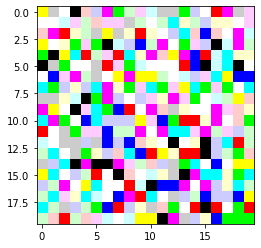

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import pandas as pd


def plot_model(model, ax):
    grid = np.zeros((model.height, model.width, 4))

    for (cell, i, j) in model.grid.coord_iter():
        color = [0,0,0,0] #in case not every cell is filled, the default colour is white
        if cell is not None:
            color = traits_to_color(cell.profile)
        grid[i,j] = color          
    plt.imshow(grid)
    
fig, ax = plt.subplots()
plot_model(model, ax)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

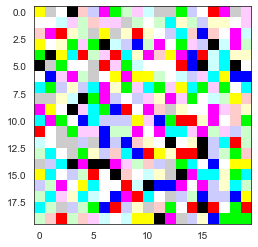

In [5]:
from matplotlib.animation import FuncAnimation
from matplotlib import animation

model = CulturalDiff(seed=123456789)
agents = model.schedule.agents

sns.set_style('white')

fig, ax = plt.subplots()
image = plot_model(model, ax)

def update(frame):
    model.step()
    grid = make_image(model)
    image.set_array(grid)
    return [image]

anim = FuncAnimation(fig, update, frames=500);
writervideo = animation.FFMpegWriter(fps=12) 
anim.save("my_model.mp4", writer=writervideo)



you could use 

```python
for _ in range(250):
    model.step()
```

if you don't want the animation, or can't make the animation work

In [ ]:
Video("my_model.mp4", width=600)

In [ ]:
import seaborn as sns
sns.set_style('white')    

model.datacollector.get_model_vars_dataframe().plot()
sns.despine()

fig = plt.gcf()
ax = plt.gca()

ax.set_xlabel('ticks')
ax.set_ylabel('# cultures')

save_fig(fig, '.', 'dynamics')

plt.show()

# Neighborhood size

The original version of the model uses a Moore neighborhood with a radius of 1. Explore the dynamics of the model with a radius ranging from 1-3. How does the dynamics of the model change, and why?

1. perform experiments for both random and weighted random selection of neighbors. Don't forget to account for the stochastic uncertainty
2. Make an appropriate visualization showing the difference in dynamics over time for both versions of the model
3. Describe in words how the behavior is different and explain this change in behavior.


# Torus

To deal with edge effects, the model assumes the use of a Torus (i.e., donut). In reality, geography matters a lot and thus edge effects can occur. Explore the dynamics of the model with and without assuming a torus. How does the behaviour of the model change, and why?

1. perform experiments for both random and weighted random selection of neighbors. Don't forget to account for the stochastic uncertainty
2. Make an appropriate visualization showing the difference in dynamics over time for both versions of the model
3. Describe in words how the behavior is different and explain this change in behavior.


# Neighbor interaction

The provided implementation assumes that interaction is random yet proportional to how similar the neighbors are. What if instead, we assume completely random interaction? How does the behavior of the model change, and why?

Note that in order to do this, you will have to change the existing implementation: 
* add a select_random keyword argument to the mode
* set select_random as a class attribute on the Agent class
* add a select_random_neigbor and select_weighted_random_neigbor method to the Agent class
* pick which select_* method to use based on the value of the select_random class attribute

1. Implement the modified model and agent
2. perform experiments for both random and weighted random selection of neighbors. Don't forget to account for the stochastic uncertainty
3. Make an appropriate visualization showing the difference in dynamics over time for both versions of the model
4. Describe in words how the behavior is different and explain this change in behavior.
5. Conceptually, how would you change the original implementation of the model as used for the first assignment such that the extensions needed for this assignment could have been implemented by merely extending the model and agent class.